In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
import scipy.optimize as op
import emcee

In [2]:
newdata = pd.read_table('PDCMAP.txt', sep='\s+')

In [3]:
alltime= np.array(newdata['Time'], 'd')
allflux = np.array(newdata['Pdcmap'], 'd')
allquarter = np.array(newdata['Quarter'], 'd')

28795 64024


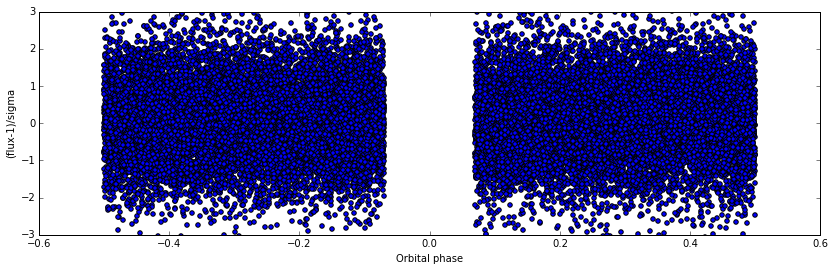

In [195]:
flag = np.zeros(len(alltime), dtype=bool)
quarters = np.unique(allquarter)

# Renormalize each quarter and remove outliers
for q in quarters:
    sel = allquarter == q
    errorf = np.std(allflux[sel])
    medianf = np.median(allflux[sel])
    finsel = np.logical_and(allquarter == q, (np.abs(allflux-medianf) <= 4.0*errorf))
    allflux[finsel] = allflux[finsel]/np.median(allflux[finsel])
    flag[finsel] = True
    
# Remove points in transit
t0 = 53.1910
p = 0.6892099

phasesaux = (alltime-t0)/p
phases = phasesaux - np.around(phasesaux)
flag[np.abs(phases) < 0.07]= False
flag[allquarter < 9]= False


    
#Retain the right points
print np.sum(flag), len(flag)
time = alltime[flag]
flux = allflux[flag] -1.0
flux = flux/np.std(flux)
quarter = allquarter[flag]
phases = phases[flag]

#plot the folded light curve to make sure we removed transits
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1,1,1)
ax.scatter(phases, flux)
plt.ylim([-3,3]) 
ax.set_ylabel('(flux-1)/sigma')
ax.set_xlabel('Orbital phase')

In [196]:
interval = 1.0 # sum invertal in days
start = np.min(time) + 0.5*interval
end = (np.around((np.max(time)-start)/interval) + 1)*interval + start
numint = (end-start)/interval

newcenters = np.linspace(start, end, numint+1, endpoint=True)
newtimes = np.empty_like(newcenters)
newfluxes = np.empty_like(newtimes)
numpoints = np.empty_like(newtimes)
newerrors = np.empty_like(newtimes)
newquarter = np.empty_like(newtimes)

for i, t0 in enumerate(newtimes):
    selected = np.abs(time-newcenters[i]) < interval*0.5
    numpoints[i] = np.sum(selected)
    if numpoints[i] > 1:
        selflux = flux[selected]
        seltimes= time[selected]
        t1 = np.median(seltimes)
        newtimes[i]  = t1
        result = np.polyfit(seltimes-t1, selflux, 1)
        newfluxes[i] = result[1] 
        newerrors[i] = np.std(selflux-result[1]-result[0]*(seltimes-t1))
        newquarter[i] = np.median(quarter[selected])


        
cadence = 29.42/(60.0*24)
        
newtimes = newtimes[numpoints > interval*0.75/cadence]
newfluxes = newfluxes[numpoints > interval*0.75/cadence]
newerrors = newerrors[numpoints > interval*0.75/cadence]

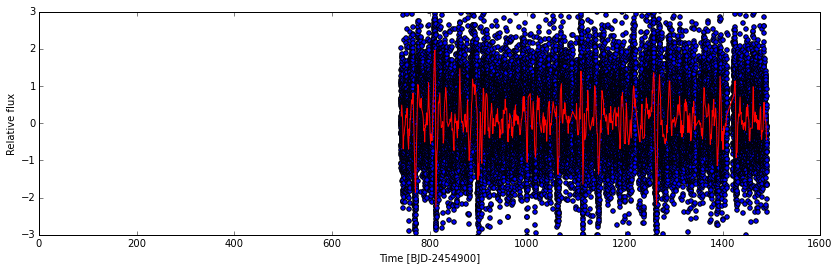

In [197]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1,1,1)
ax.scatter(time, flux)
plt.xlim([0,1600]) 
plt.ylim([-3,3]) 
ax.set_xlabel('Time [BJD-2454900]')
ax.set_ylabel('Relative flux')
ax.plot(newtimes, newfluxes, 'r')

In [198]:
def lnlike(theta, time, flux, error):
    gamma, prot, h, sigma, alpha = theta 

    gp = george.GP(kernels.WhiteKernel(sigma**2) + (kernels.ExpSquaredKernel(alpha**2)*
                                                    (kernels.ExpSine2Kernel(gamma, prot))*h**2))
    gp.compute(time, error)
    return gp.lnlikelihood(flux)

In [209]:
def lnprior(theta):
    gamma, prot, h, sigma, alpha = theta 
    if (0< sigma) and (0 < alpha <= 100.0) and (0 <= gamma <= 1000) and (0 <= h) and (0 < prot < 100):
        return 0.0
    return -np.inf

In [210]:
def lnprob(theta, time, flux, error):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, time, flux, error)

In [211]:
nll = lambda *args: -lnprob(*args)
result = op.minimize(nll, [1.0, 32, 1.0, 1.0, 1.0], 
                     args=(newtimes, newfluxes, 0.1*newerrors), tol=0.01, options={'disp': True, 'maxiter':100000})
gamma_ml, prot_ml, h_ml,sigma_ml, alpha_ml = result["x"]  
print result["x"]

         Current function value: 236.804331
         Iterations: 6
         Function evaluations: 182
         Gradient evaluations: 22
[  0.03242808  32.0461667    0.47872746   0.15406294   1.61388969]


In [212]:
ndim, nwalkers = 5, 100
pos = [result["x"]*(1+5e-3*np.random.randn(ndim)) for i in range(nwalkers)]

In [213]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(newtimes, newfluxes, newerrors))
sampler.run_mcmc(pos, 1000)

(array([[  3.20120736e+00,   2.69938786e+01,   1.41612451e-01,
           6.63094138e-02,   9.83425190e+01],
        [  2.35189368e+01,   5.32278057e+01,   1.02697336e-01,
           4.79327229e-02,   7.91451932e+01],
        [  3.63145501e+02,   3.50942126e+01,   3.09383170e-02,
           3.00170548e-02,   7.01273365e+01],
        [  3.09668844e+01,   5.52634139e+01,   2.15839030e-01,
           6.90527890e-02,   7.19967739e+01],
        [  4.23117695e+01,   5.76338583e+01,   1.84717589e-01,
           3.22859145e-02,   7.32660440e+01],
        [  1.13667713e+02,   9.50608983e+01,   3.19870497e-01,
           7.82205322e-03,   6.82562284e+01],
        [  3.81478494e+02,   9.02110819e+01,   7.14796223e-02,
           3.69404257e-02,   2.30626789e+01],
        [  7.21727988e+01,   7.93544583e+01,   1.44227125e-01,
           1.35089204e-02,   9.90136398e+01],
        [  2.29122864e+02,   4.33846887e+01,   1.60119187e-02,
           6.30591481e-04,   2.88018738e+01],
        [  3.233756

In [214]:
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) #Burn in portion to remove (currently %10)

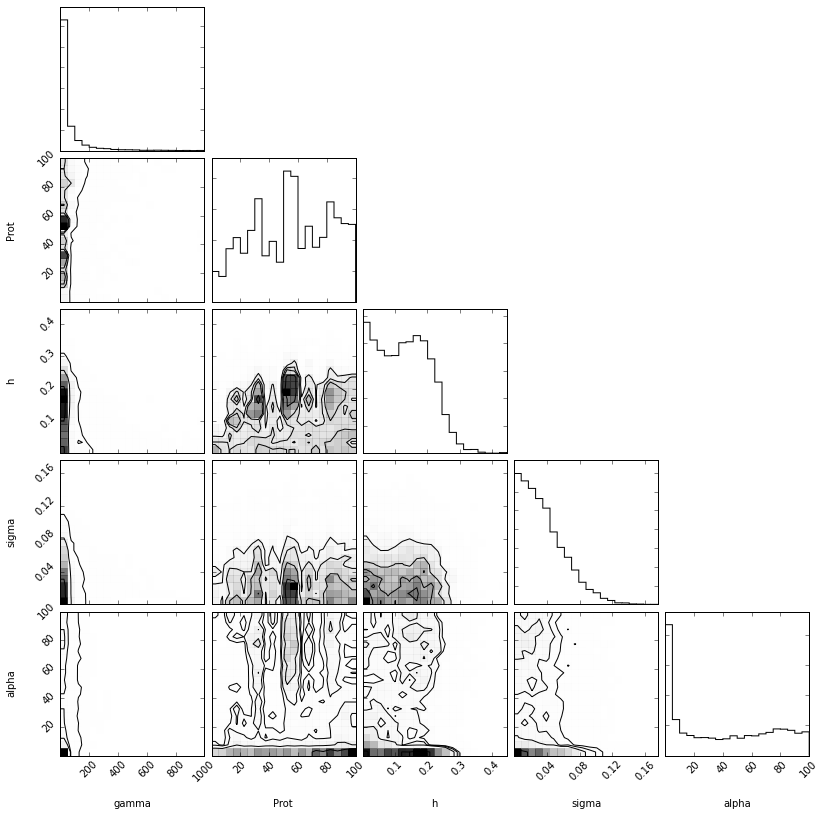

In [215]:
import triangle
fig = triangle.corner(samples, labels=["gamma", "Prot", "h", "sigma", "alpha"]) #truths=[m_true, b_true, np.log(f_true)   , 
fig.savefig("triangle.png")

In [216]:
(gamma_mcmc, prot_mcmc, h_mcmc, sigma_mcmc, alpha_mcmc) = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                                  zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))

In [217]:
print('Gamma value {0:3.2f} +{1:3.2f} - {1:3.2f}' .format(gamma_mcmc[0],gamma_mcmc[1], gamma_mcmc[2] ))
print('Prot value {0:3.2f} +{1:3.2f} - {1:3.2f}' .format(prot_mcmc[0],prot_mcmc[1], prot_mcmc[2] ))
print('Alpha value {0:3.2f} +{1:3.2f} - {1:3.2f}' .format(alpha_mcmc[0],alpha_mcmc[1], alpha_mcmc[2] ))

Gamma value 18.82 +90.79 - 90.79
Prot value 55.31 +30.61 - 30.61
Alpha value 37.63 +44.75 - 44.75
